In [1]:
#all needed imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
from folium.plugins import HeatMap
from shapely.geometry import Point

# California Fire Analysis


In [2]:
#loading csv file "california fire incidents" from https://www.kaggle.com/datasets/ananthu017/california-wildfire-incidents-20132020/
df = pd.read_csv(r"C:\Users\alish\Desktop\California_Fire_Incidents.csv") 
print(df)

      AcresBurned  Active                                          AdminUnit  \
0        257314.0   False  Stanislaus National Forest/Yosemite National Park   
1         30274.0   False  USFS Angeles National Forest/Los Angeles Count...   
2         27531.0   False  CAL FIRE Riverside Unit / San Bernardino Natio...   
3         27440.0   False                              Tahoe National Forest   
4         24251.0   False                       Ventura County Fire/CAL FIRE   
...           ...     ...                                                ...   
1631          9.0   False                   CAL FIRE / Riverside County Fire   
1632          2.0   False                  CAL FIRE Nevada-Yuba-Placer Unit    
1633          NaN   False               Yolo County Fire Protection District   
1634          NaN   False                   Camp Pendleton Marine Corps Base   
1635          NaN   False                           Bureau of Indian Affairs   

      AirTankers  ArchiveYear  CalFireI

Cleaning dataset

In [3]:
#removing duplicate data
df = df.drop_duplicates() 

#removing columns not required for current analysis
df = df.drop(columns = ['CanonicalUrl','Location','ConditionStatement','ControlStatement', 'SearchDescription','SearchKeywords']) 
print(df.columns)

Index(['AcresBurned', 'Active', 'AdminUnit', 'AirTankers', 'ArchiveYear',
       'CalFireIncident', 'Counties', 'CountyIds', 'CrewsInvolved', 'Dozers',
       'Engines', 'Extinguished', 'Fatalities', 'Featured', 'Final',
       'FuelType', 'Helicopters', 'Injuries', 'Latitude', 'Longitude',
       'MajorIncident', 'Name', 'PercentContained', 'PersonnelInvolved',
       'Public', 'Started', 'Status', 'StructuresDamaged',
       'StructuresDestroyed', 'StructuresEvacuated', 'StructuresThreatened',
       'UniqueId', 'Updated', 'WaterTenders'],
      dtype='object')


# Mapping California Fires 

In [4]:
# Format ISO8601 - the international date/time standard
df['Started'] = pd.to_datetime(df['Started'], format='ISO8601')

In [5]:
#converting into a geodataframe with a new geometry column
# resource for crs - geopandas.org/en/v0.10.1/gallery/polygon_plotting_with_folium.html
df_map = gpd.GeoDataFrame(df,geometry = gpd.points_from_xy(df.Longitude,df.Latitude)) #important that longitude comes first

crs = 'epsg:4326' #setting coordinate reference system
geo_map = gpd.GeoDataFrame(df_map, crs=crs, geometry='geometry') #dataframe for all plotting is geo_map
print(geo_map)

      AcresBurned  Active                                          AdminUnit  \
0        257314.0   False  Stanislaus National Forest/Yosemite National Park   
1         30274.0   False  USFS Angeles National Forest/Los Angeles Count...   
2         27531.0   False  CAL FIRE Riverside Unit / San Bernardino Natio...   
3         27440.0   False                              Tahoe National Forest   
4         24251.0   False                       Ventura County Fire/CAL FIRE   
...           ...     ...                                                ...   
1631          9.0   False                   CAL FIRE / Riverside County Fire   
1632          2.0   False                  CAL FIRE Nevada-Yuba-Placer Unit    
1633          NaN   False               Yolo County Fire Protection District   
1634          NaN   False                   Camp Pendleton Marine Corps Base   
1635          NaN   False                           Bureau of Indian Affairs   

      AirTankers  ArchiveYear  CalFireI

Using geopandas and matplotlib to plot California fires 

C:\Users\alish\AppData\Local\Temp\ipykernel_22716\4023768313.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


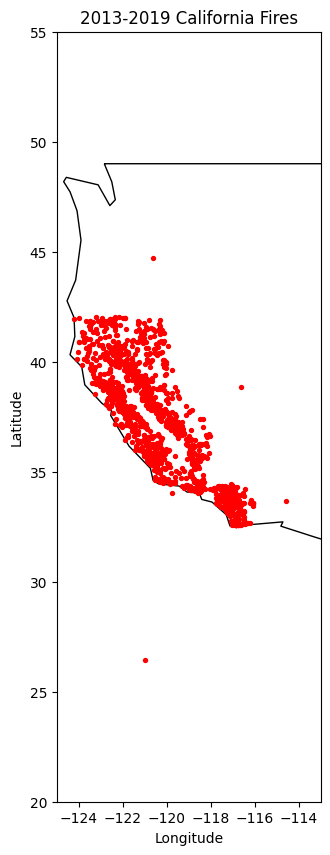

In [6]:
#code reference - https://www.youtube.com/watch?v=5G-1k4CNChI 
# Load built in dataset with countries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract California from the world dataset
california = world[world['name'] == 'United States of America']

# setting up adjustable bounds for viewing 
california_bounds = (-125, 20, -113, 55) 

# plot map with the specified bounds
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(california_bounds[0], california_bounds[2])
ax.set_ylim(california_bounds[1], california_bounds[3])


california.plot(ax=ax, color='white', edgecolor='black')
df_map.plot(ax=ax, color='red', markersize=8)

#labelling
ax.set_title('2013-2019 California Fires')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


#Deprecation warning will be shown - needs to be updated for future versions
plt.show()  

Mapping fires with folium and geopandas - as an interactive version

In [7]:
#resource for folium used: https://python-visualization.github.io/folium/latest/getting_started.html 
# Create a Folium map centered in california (I chose lake tahoe as the center) can adjust center and zoom level
dot_map = folium.Map(location=[39, -120], zoom_start=9)


# overlay the geodatafram with points onto the map
for idx, row in geo_map.iterrows():  #iterates through each row for lat and lon to place point
    folium.Marker(location=[row['Latitude'], row['Longitude']]).add_to(dot_map)
dot_map


In [8]:
# Create a new folium map with same data - heatmap version
heat_map = folium.Map(location=[39, -120], zoom_start=6)


# making a heatmap layer and adding it 
heat_data = [[point.xy[1][0], point.xy[0][0]] for point in geo_map.geometry]#lists with lat and lon of points
HeatMap(heat_data).add_to(heat_map) #using heatmap function from folium

heat_map

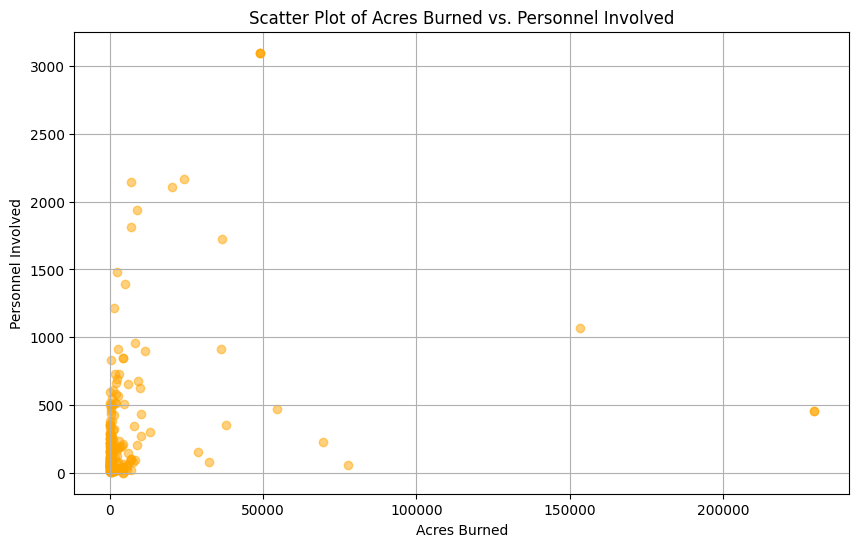

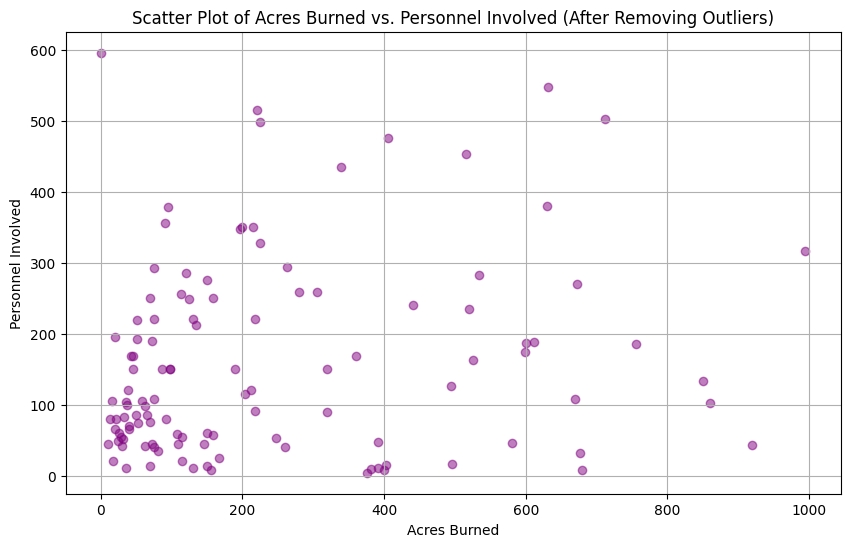

In [9]:
#resource - towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba 
# interquartile ranges calculation for both columns- looks at top and botton 25%
Q1_AcresBurned = df['AcresBurned'].quantile(0.25)
Q3_AcresBurned = df['AcresBurned'].quantile(0.75)
IQR_AcresBurned = Q3_AcresBurned - Q1_AcresBurned

Q1_PersonnelInvolved = df['PersonnelInvolved'].quantile(0.25)
Q3_PersonnelInvolved = df['PersonnelInvolved'].quantile(0.75)
IQR_PersonnelInvolved = Q3_PersonnelInvolved - Q1_PersonnelInvolved



# creating the upper and lower bounds for both columns
lower_b_AcresBurned = Q1_AcresBurned - 1.5 * IQR_AcresBurned
upper_b_AcresBurned = Q3_AcresBurned + 1.5 * IQR_AcresBurned

lower_b_PersonnelInvolved = Q1_PersonnelInvolved - 1.5 * IQR_PersonnelInvolved
upper_b_PersonnelInvolved = Q3_PersonnelInvolved + 1.5 * IQR_PersonnelInvolved



# removing outliers based on the bounds for both columns
df_no_outliers = df[(df['AcresBurned'] >= lower_b_AcresBurned) & (df['AcresBurned'] <= upper_b_AcresBurned) &
                   (df['PersonnelInvolved'] >= lower_b_PersonnelInvolved) & (df['PersonnelInvolved'] <= upper_b_PersonnelInvolved)]



# creating a scatter plot to show relationship between acres burned and personnel involved
plt.figure(figsize=(10, 6))
plt.scatter(df['AcresBurned'], df['PersonnelInvolved'], color='orange', alpha=0.5)
plt.title('Scatter Plot of Acres Burned vs. Personnel Involved')
plt.xlabel('Acres Burned')
plt.ylabel('Personnel Involved')
plt.grid(True)
plt.show()



# the scatter plot without the outliers
plt.figure(figsize=(10, 6))
plt.scatter(df_no_outliers['AcresBurned'], df_no_outliers['PersonnelInvolved'], color='purple', alpha=0.5)
plt.title('Scatter Plot of Acres Burned vs. Personnel Involved (After Removing Outliers)')
plt.xlabel('Acres Burned')
plt.ylabel('Personnel Involved')
plt.grid(True)
plt.show()

# Data Search Tool

In [10]:
def get_fire_statistics(df, fire_name):
   if fire_name not in df['Name'].values:
       return f"No data found for fire: {fire_name}"

   fire_data = df[df['Name'] == fire_name].iloc[0] #returns row specific information through fire name 

   fire_statistics = f"Fire Name: {fire_name}\n"
   fire_statistics += f"Acres Burned: {fire_data['AcresBurned']}\n"
   fire_statistics += f"Admin Unit: {fire_data['AdminUnit']}\n"
   fire_statistics += f"Air Tankers: {fire_data['AirTankers']}\n"

   return fire_statistics


def get_county_statistics(df, user_input): #called when county entered, finds averages for acresburned and sum for incidents and acres
   county_data = df[df['Counties'] == user_input]

   total_incidents = len(county_data)
   total_acres_burned = county_data['AcresBurned'].sum()
   average_acres_burned = total_acres_burned / total_incidents if total_incidents > 0 else 0 #more columns can be added based on information needs

   return total_incidents, total_acres_burned, average_acres_burned



user_input = input("Enter name of county or fire event: ") #question for user input



if user_input in df['Counties'].values:  #checking that a county name is enterred and returning 
   total_incidents, total_acres_burned, average_acres_burned = get_county_statistics(df, user_input)
   print(f"Total Incidents: {total_incidents}")
   print(f"Total Acres Burned: {total_acres_burned}")
   print(f"Average Acres Burned: {average_acres_burned}")


elif user_input in df['Name'].values: #when a non county is named, we check if its a fire name
   fire_statistics = get_fire_statistics(df, user_input) 
   print(fire_statistics)


else:
   print("California does have a lot of weird names but this isn't one") #when user inputs a name that isn't in dataset

Enter name of county or fire event: Monterey
Total Incidents: 45
Total Acres Burned: 156566.0
Average Acres Burned: 3479.2444444444445
